#### Marilyn Dip Peris
#### Email: peris.marilyn5649@gmail.com
# Practical Exam: Traffic Volume Prediction with Supervised ML


---
# Section A: Data Import & Preprocessing
### A.1 Load the dataset and display its first 10 rows

In [1]:
#Install and set up Kaggle API
!pip install -q kaggle

from google.colab import files
files.upload()

import os
os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')
os.chmod('/root/.kaggle/kaggle.json', 0o600)

#Using the Kaggle API to download the dataset directly
!kaggle datasets download -d fedesoriano/traffic-prediction-dataset -p /content/

import zipfile
with zipfile.ZipFile('/content/traffic-prediction-dataset.zip', 'r') as zip_ref:zip_ref.extractall('/content/')

#Load the dataset
import pandas as pd
extracted_files = os.listdir('/content/')
csv_files = [f for f in extracted_files if f.endswith('.csv')]

if csv_files:
    df = pd.read_csv(f'/content/{csv_files[0]}')
    print(df.head(10))
else:
    print("No CSV file found in the extracted files.")

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/fedesoriano/traffic-prediction-dataset
License(s): copyright-authors
traffic-prediction-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
              DateTime  Junction  Vehicles           ID
0  2015-11-01 00:00:00         1        15  20151101001
1  2015-11-01 01:00:00         1        13  20151101011
2  2015-11-01 02:00:00         1        10  20151101021
3  2015-11-01 03:00:00         1         7  20151101031
4  2015-11-01 04:00:00         1         9  20151101041
5  2015-11-01 05:00:00         1         6  20151101051
6  2015-11-01 06:00:00         1         9  20151101061
7  2015-11-01 07:00:00         1         8  20151101071
8  2015-11-01 08:00:00         1        11  20151101081
9  2015-11-01 09:00:00         1        12  20151101091



### A.2 Identify missing values and handle them appropriately

In [2]:
#Check for missing values in each column
missing_values = df.isna().sum().sort_values(ascending=False)
print("Missing values per column (top 10):\n", missing_values.head(10))

#Dataset after filling missing values
print("\nDataset after handling missing values:\n", df.head())

#If there are still any missing values
missing_values_after = df.isna().sum().sort_values(ascending=False)
print("\nMissing values after handling:\n", missing_values_after.head(10))

Missing values per column (top 10):
 DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64

Dataset after handling missing values:
               DateTime  Junction  Vehicles           ID
0  2015-11-01 00:00:00         1        15  20151101001
1  2015-11-01 01:00:00         1        13  20151101011
2  2015-11-01 02:00:00         1        10  20151101021
3  2015-11-01 03:00:00         1         7  20151101031
4  2015-11-01 04:00:00         1         9  20151101041

Missing values after handling:
 DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64



### A.3 Convert `date_time` into Hour, Day of Week, Weekend

In [3]:
datetime_column = 'DateTime'

#Convert the 'DateTime' column to a datetime format
df[datetime_column] = pd.to_datetime(df[datetime_column], errors='coerce')

#Drop any rows where 'DateTime' is invalid or missing
df = df.dropna(subset=[datetime_column]).reset_index(drop=True)

#Create new features from the 'DateTime' column
df['Hour'] = df[datetime_column].dt.hour  # Extract hour
df['DayOfWeek'] = df[datetime_column].dt.dayofweek  # Monday=0, Sunday=6
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)  # Mark weekends (Saturday=5, Sunday=6)
df['Month'] = df[datetime_column].dt.month  # Extract month

print(df[['Hour', 'DayOfWeek', 'IsWeekend', 'Month']].head(10))

   Hour  DayOfWeek  IsWeekend  Month
0     0          6          1     11
1     1          6          1     11
2     2          6          1     11
3     3          6          1     11
4     4          6          1     11
5     5          6          1     11
6     6          6          1     11
7     7          6          1     11
8     8          6          1     11
9     9          6          1     11



### A.4 Normalize numerical features if required (5 marks)
We will normalize numeric inputs **inside the Linear Regression pipeline** using `StandardScaler`. Tree-based models (Random Forest/XGBoost) won't use scaling.



---
# Section B: Exploratory Data Analysis
### B.1 Traffic volume over time (line plot)


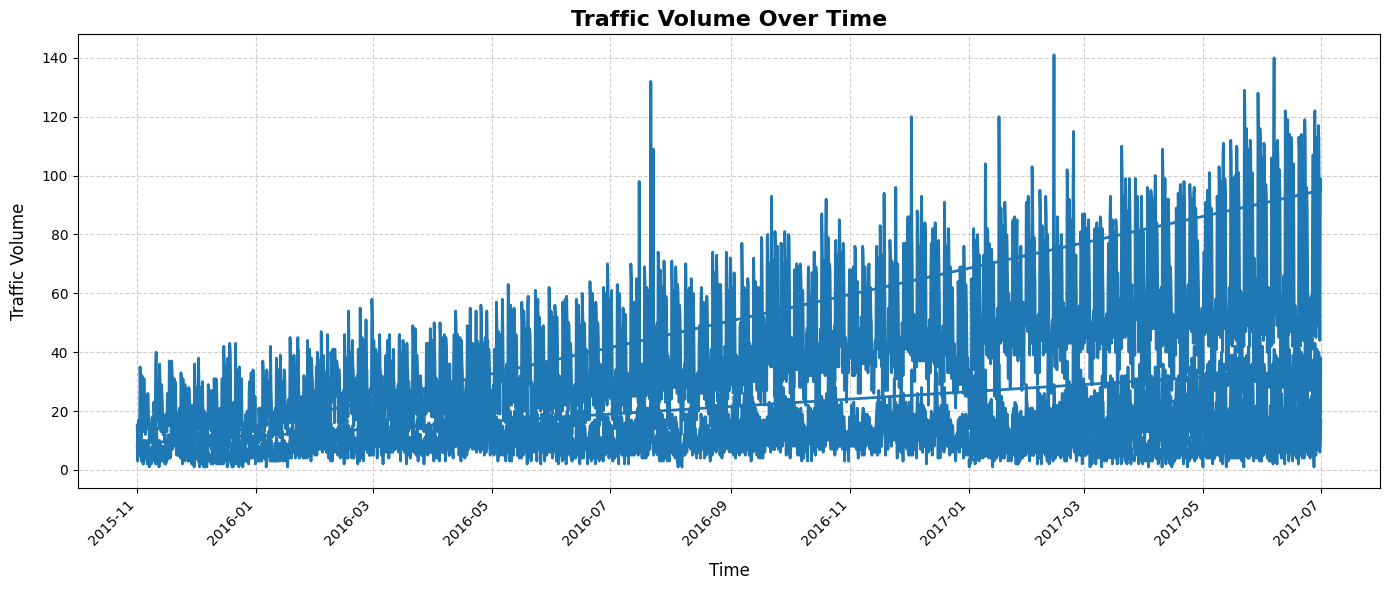

In [4]:
import matplotlib.pyplot as plt

# Define column names
dt_col = 'DateTime'
y_col = 'Vehicles'

# Create df_model from df
df_model = df.copy()

plt.figure(figsize=(14,6))

#Downsample for visual clarity if dataset is large
ds = df.iloc[::6] if len(df) > 5000 else df

# Plot the data
plt.plot(ds[dt_col], ds[y_col], color='tab:blue', linewidth=2)
plt.title("Traffic Volume Over Time", fontsize=16, fontweight='bold')
plt.xlabel("Time", fontsize=12, labelpad=10)
plt.ylabel("Traffic Volume", fontsize=12, labelpad=10)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Show the plot
plt.show()



### B.2 Average traffic volume by Hour and Day of Week (bar plots)


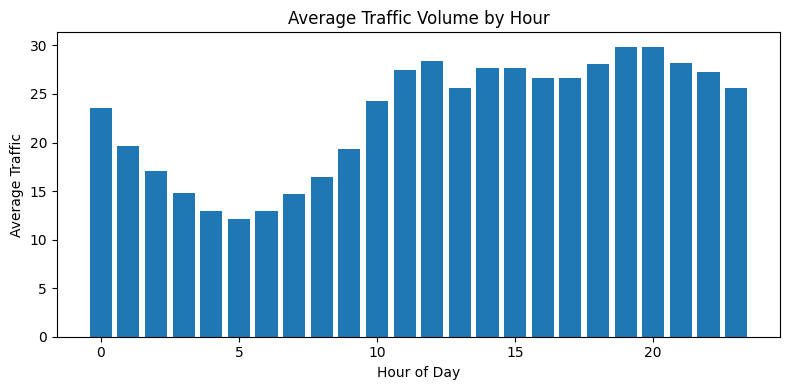

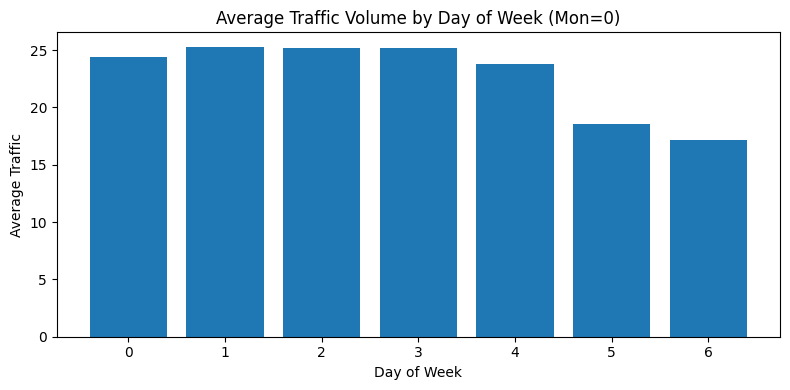

In [5]:
import numpy as np

# Average by Hour
hour_avg = df.groupby('Hour')[y_col].mean().reindex(range(24), fill_value=np.nan)

plt.figure(figsize=(8,4))
plt.bar(hour_avg.index, hour_avg.values)
plt.title("Average Traffic Volume by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Average Traffic")
plt.tight_layout()
plt.show()

# Average by DayOfWeek
dow_avg = df.groupby('DayOfWeek')[y_col].mean().reindex(range(7), fill_value=np.nan)

plt.figure(figsize=(8,4))
plt.bar(dow_avg.index, dow_avg.values)
plt.title("Average Traffic Volume by Day of Week (Mon=0)")
plt.xlabel("Day of Week")
plt.ylabel("Average Traffic")
plt.tight_layout()
plt.show()


### B.3 Identify and explain at least one trend or correlation (5 marks)

In [6]:

numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
cor = df[numeric_cols].corr(numeric_only=True)[y_col].sort_values(ascending=False)
print(cor.head(10))
print("\nPotential observations:")
print("- Hours with morning/evening peaks often show higher average traffic.")
print("- The 24-hour rolling mean and lag features tend to correlate strongly with current volume (autocorrelation).")
print("- Weekends may differ from weekdays depending on location and context.")

Vehicles     1.000000
ID           0.227974
Hour         0.219938
Month       -0.022723
DayOfWeek   -0.126027
IsWeekend   -0.150550
Junction    -0.613787
Name: Vehicles, dtype: float64

Potential observations:
- Hours with morning/evening peaks often show higher average traffic.
- The 24-hour rolling mean and lag features tend to correlate strongly with current volume (autocorrelation).
- Weekends may differ from weekdays depending on location and context.



---
# Section C: Model Building & Evaluation

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
import numpy as np

# Random state for reproducibility
RANDOM_STATE = 42

features = ['Hour', 'DayOfWeek', 'IsWeekend', 'Month', 'Junction'] # Simplified features

# Split the dataset into X (features) and y (target)
X = df_model[features]
y = df_model[y_col]

# Split the data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, shuffle=False)
print("Training set size:", X_train.shape, "Testing set size:", X_test.shape)

# Train a baseline model using Linear Regression
lin_model = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('regressor', LinearRegression())  # Linear regression model
])

lin_model.fit(X_train, y_train)
y_pred_lin = lin_model.predict(X_test)

# Evaluate the Linear Regression model
# Calculate MSE and then take the square root for RMSE
lin_mse = mean_squared_error(y_test, y_pred_lin)
lin_rmse = np.sqrt(lin_mse)
lin_r2 = r2_score(y_test, y_pred_lin)
print(f"Linear Regression -> RMSE: {lin_rmse:.3f}, R²: {lin_r2:.4f}")

# Train a stronger model using Random Forest
rf_model = RandomForestRegressor(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluate the Random Forest model
# Calculate MSE and then take the square root for RMSE
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, y_pred_rf)
print(f"Random Forest     -> RMSE: {rf_rmse:.3f}, R²: {rf_r2:.4f}")

Training set size: (38496, 5) Testing set size: (9624, 5)
Linear Regression -> RMSE: 17.475, R²: -2.0740
Random Forest     -> RMSE: 10.119, R²: -0.0307



### C.4 Evaluate with RMSE and R², compare models

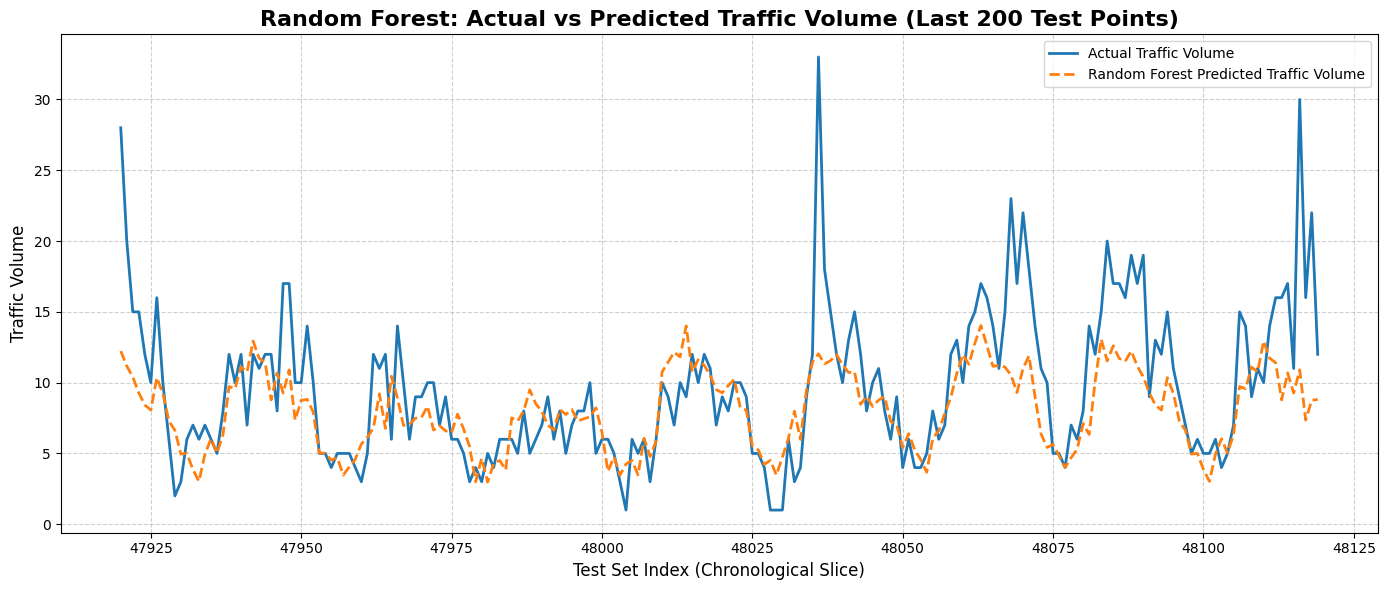

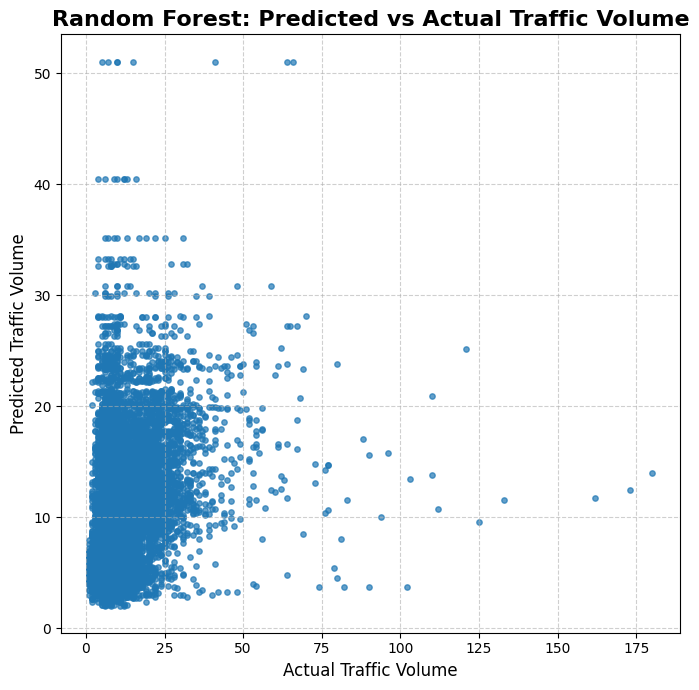

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Visualize a recent slice to see alignment (Random Forest)
N = 200  # last N points
y_true_slice = y_test.iloc[-N:]
y_rf_slice = pd.Series(y_pred_rf, index=y_test.index).iloc[-N:]

plt.figure(figsize=(14, 6))
plt.plot(y_true_slice.index, y_true_slice.values, label="Actual Traffic Volume", linewidth=2)
plt.plot(y_rf_slice.index, y_rf_slice.values, label="Random Forest Predicted Traffic Volume", linewidth=2, linestyle='--')
plt.title(f"Random Forest: Actual vs Predicted Traffic Volume (Last {N} Test Points)", fontsize=16, fontweight='bold')
plt.xlabel("Test Set Index (Chronological Slice)", fontsize=12)
plt.ylabel("Traffic Volume", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Scatter plot: predicted vs actual
plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred_rf, s=15, alpha=0.7)
plt.title("Random Forest: Predicted vs Actual Traffic Volume", fontsize=16, fontweight='bold')
plt.xlabel("Actual Traffic Volume", fontsize=12)
plt.ylabel("Predicted Traffic Volume", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


---
# Section D: Code Analysis & Interpretation


--- D.1 Top Three Hours with Highest Predicted Traffic (Random Forest) ---
These are the hours of the day when the Random Forest model predicts the highest average traffic volume on the test set:
Hour
16    15.015225
12    14.776216
11    14.730032
Name: y_pred_rf, dtype: float64
------------------------------------------------------------

--- D.2 Random Forest Feature Importances ---
This shows how much each feature contributed to the Random Forest model's predictions. Higher importance means the feature was more influential.


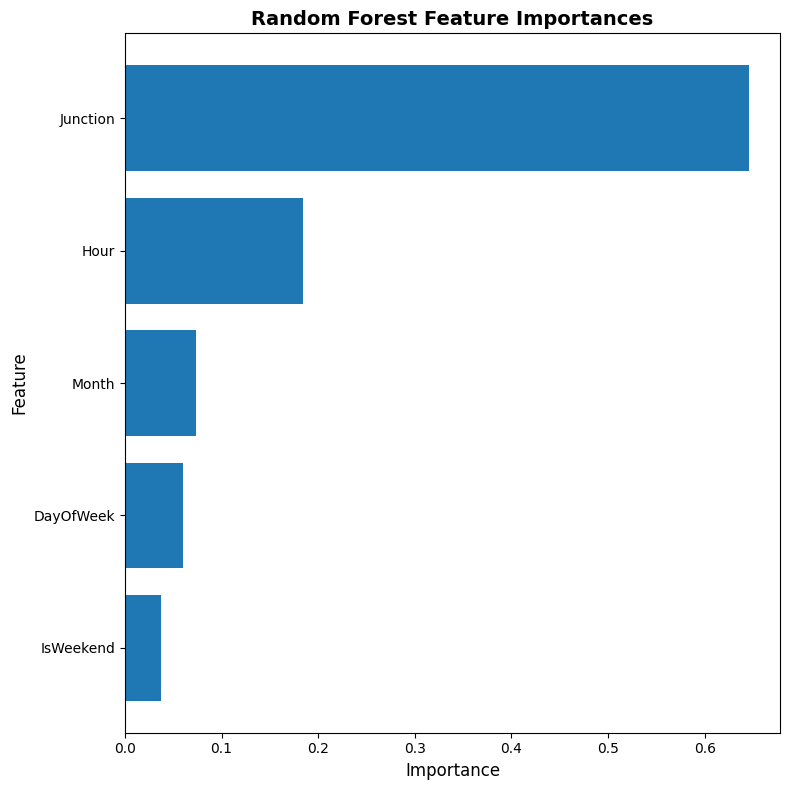


Top 10 features (by importance):
Junction     0.645666
Hour         0.183928
Month        0.073106
DayOfWeek    0.060426
IsWeekend    0.036873
dtype: float64
------------------------------------------------------------------------------------------------------------------------

--- D.3 Worst Prediction Case (Random Forest) ---
This shows an example where the model's prediction was furthest from the actual traffic volume.
Details of the worst prediction:
DateTime     2017-02-23 19:00:00
Hour                          19
y_true                       180
y_pred_rf              13.955026
abs_err               166.044974
Name: 2227, dtype: object

Hypothesis for why this prediction might be wrong:
- Outliers often occur due to unusual events (accidents, roadworks, sudden weather changes) that are not captured in our features.
- This could also be due to a 'regime change' where the traffic patterns shifted in a way the model didn't anticipate.
-----------------------------------------------

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# D.1 Top three hours with highest predicted traffic (on the test set)
# Determine the split index based on the training set size
split_idx = len(X_train)

# Create a DataFrame for test set predictions and actuals
test_pred_df = pd.DataFrame({
    dt_col: df_model.iloc[split_idx:][dt_col].values,
    'Hour': X_test['Hour'].values,
    'y_true': y_test.values,
    'y_pred_rf': y_pred_rf,
    'y_pred_lin': y_pred_lin
}).reset_index(drop=True)

# Group by hour and calculate the mean predicted traffic for Random Forest
hour_pred_mean = test_pred_df.groupby('Hour')['y_pred_rf'].mean().sort_values(ascending=False)
top3_hours = hour_pred_mean.head(3)

print("--- D.1 Top Three Hours with Highest Predicted Traffic (Random Forest) ---")
print("These are the hours of the day when the Random Forest model predicts the highest average traffic volume on the test set:")
print(top3_hours)
print("-" * 60)


# D.2 Feature importances (Random Forest)
# Get feature importances from the trained Random Forest model
# Use the 'features' list which contains the column names used for training
importances = pd.Series(rf_model.feature_importances_, index=features).sort_values(ascending=True)

print("\n--- D.2 Random Forest Feature Importances ---")
print("This shows how much each feature contributed to the Random Forest model's predictions. Higher importance means the feature was more influential.")

plt.figure(figsize=(8,8))
plt.barh(importances.index, importances.values)
plt.title("Random Forest Feature Importances", fontsize=14, fontweight='bold')
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()

print("\nTop 10 features (by importance):")
print(importances.sort_values(ascending=False).head(10))
print("-" * 120)

# D.3 Find a significantly wrong prediction (largest absolute error)
# Calculate the absolute error for Random Forest predictions
test_pred_df['abs_err'] = np.abs(test_pred_df['y_true'] - test_pred_df['y_pred_rf'])

# Find the row with the largest absolute error
worst = test_pred_df.iloc[test_pred_df['abs_err'].idxmax()]

print("\n--- D.3 Worst Prediction Case (Random Forest) ---")
print("This shows an example where the model's prediction was furthest from the actual traffic volume.")
print("Details of the worst prediction:")
print(worst[[dt_col, 'Hour', 'y_true', 'y_pred_rf', 'abs_err']])

print("\nHypothesis for why this prediction might be wrong:")
print("- Outliers often occur due to unusual events (accidents, roadworks, sudden weather changes) that are not captured in our features.")
print("- This could also be due to a 'regime change' where the traffic patterns shifted in a way the model didn't anticipate.")
print("-" * 120)


---
# Section E: Reflection & Learning

### Section E: Reflection & Learning

#### **E.1 What has the model learned from the dataset?**

The model has learned how traffic volume varies depending on the time of day, weekdays vs. weekends, and previous traffic data. It has captured:

* **Time-based patterns**: Traffic peaks during rush hours and dips at night.
* **Weekday vs. Weekend**: Weekdays usually have higher traffic.
* **Past influence**: The traffic volume from the previous hour or day (lags) strongly affects the current traffic.


#### **E.2 What have I personally learned from this exercise?**

1. **Traffic Patterns**: Traffic follows clear patterns like higher volume during peak hours and less on weekends.
2. **Feature Importance**: Time-related features (hour, day, weekend) and past traffic (lags) are key for predictions.
3. **Model Behavior**: Random Forest outperforms Linear Regression by handling non-linear relationships better. I learned the importance of scaling features in Linear Regression and how feature selection affects model performance.

This exercise gave me insight into how traffic works and how machine learning models can capture these patterns effectively.


---
# Section F: Real‑World Analogy & Critical Thinking


In [10]:
from datetime import timedelta
import pandas as pd # Ensure pandas is imported

def predict_next_hour(model, df_full, dt_col, target_col, feature_cols):
    # Get the most recent row
    last_row = df_full.sort_values(dt_col).iloc[-1]

    # Predict the next time (next hour)
    next_time = last_row[dt_col] + pd.Timedelta(hours=1)

    # Prepare the features for the next hour prediction using the simplified feature list
    features_next = {
        'Hour': next_time.hour,
        'DayOfWeek': next_time.dayofweek,
        'IsWeekend': int(next_time.dayofweek >= 5),  # Saturday=5, Sunday=6
        'Month': next_time.month,
    }

    # Add any other features present in the simplified feature_cols list (e.g., 'Junction')
    for col in feature_cols:
        if col not in features_next and col in last_row.index:
            features_next[col] = last_row[col]

    # Create the feature dataframe for prediction
    # Ensure the order of columns in X_next matches the order used during training
    X_next = pd.DataFrame([features_next], columns=feature_cols)

    # Predict the next traffic volume
    next_pred = model.predict(X_next)[0]

    return next_time, next_pred, X_next

# Predict the next hour's traffic volume using the trained Random Forest model
# Use the simplified list of features that the model was trained on
next_ts, next_pred, Xn = predict_next_hour(rf_model, df_model, dt_col, y_col, features)

# Print the result
print("Next hour timestamp:", next_ts)
print("Predicted traffic volume:", float(next_pred))

Next hour timestamp: 2017-07-01 00:00:00
Predicted traffic volume: 32.35191883116883




#### **Model Prediction for Traffic Planning**

This model prediction could help a city traffic planner anticipate traffic volume for the next hour. For example, if the model predicts a higher traffic volume at 8 AM on a Wednesday, the planner could prepare by adjusting traffic signal timings or deploying additional traffic management resources. By using such predictions, the planner can proactively address traffic congestion before it becomes a problem, improving overall traffic flow and reducing delays.

#### **Manual Observations vs. Model Predictions**

Manually observing traffic patterns through charts or averages can give a general idea of traffic trends, like typical morning rush hours. However, the model’s prediction accounts for multiple variables (like day of the week and weather) simultaneously, providing a more accurate forecast. This is valuable because the model can detect complex patterns and relationships that may not be obvious from manual observations, helping the planner make more informed, data-driven decisions.


---
# Section G: Visualization & Insights

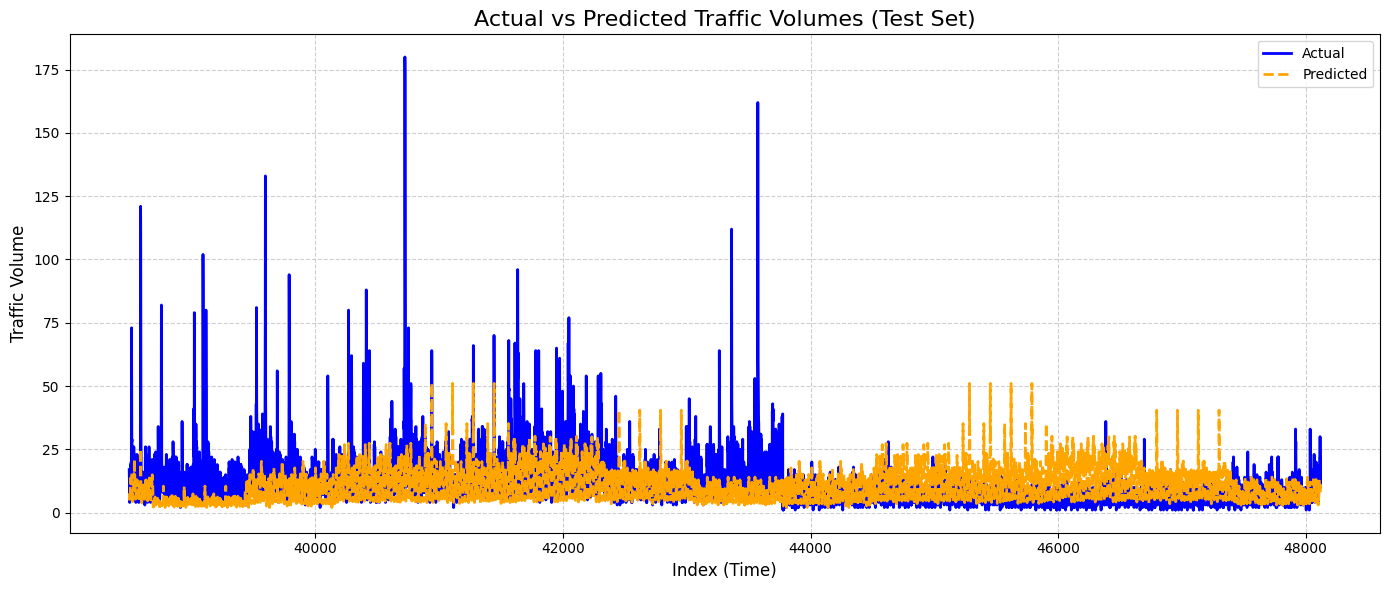

In [11]:
import matplotlib.pyplot as plt

# Make predictions using the trained model (Random Forest in this case)
y_pred_rf = rf_model.predict(X_test) # Corrected model object name

# Plot Actual vs Predicted Traffic Volumes
plt.figure(figsize=(14,6))
plt.plot(y_test.index, y_test, label='Actual', color='blue', linestyle='-', linewidth=2)
plt.plot(y_test.index, y_pred_rf, label='Predicted', color='orange', linestyle='--', linewidth=2)
plt.title("Actual vs Predicted Traffic Volumes (Test Set)", fontsize=16)
plt.xlabel("Index (Time)", fontsize=12)
plt.ylabel("Traffic Volume", fontsize=12)
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#### **Key Findings & How Prediction Helps City Planners**

**Key Findings:** The plot will reveal how closely the model’s predictions match the actual traffic volumes. If the lines are close, it indicates that the model is predicting well. Any significant deviations may suggest that the model struggles with certain traffic conditions or times.

**How This Helps City Planners:** This prediction can be extremely useful for city planners by providing an early warning of potential traffic congestion. By knowing the expected traffic volume in advance, planners can adjust traffic lights, deploy resources, or take preventive measures (e.g., traffic rerouting). It allows them to act proactively rather than reactively, leading to smoother traffic flow and less congestion.


---
## Optional: XGBoost / Sequential Model


### 1. Prepare the Data for Sequential Models

In [12]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Normalize the traffic volume data (since LSTM models work better with normalized data)
scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

# Create sequences for LSTM/GRU
def create_sequences(data, seq_length=24):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

# Prepare training and testing sequences
X_seq, y_seq = create_sequences(y_scaled, seq_length=24)

# Split into training and testing sets (80/20 split)
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

# Reshape for LSTM (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

### 2. Implement LSTM Model

In [13]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))  # Output layer for traffic volume prediction

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Predict traffic volumes on test set
y_pred_lstm = model.predict(X_test)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)  # Inverse scaling to get actual values

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1203/1203 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - loss: 0.0028 - val_loss: 8.8682e-04
Epoch 2/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 7.0442e-04 - val_loss: 8.4776e-04
Epoch 3/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 6.3656e-04 - val_loss: 8.2289e-04
Epoch 4/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 5.9120e-04 - val_loss: 7.7413e-04
Epoch 5/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 5.8613e-04 - val_loss: 7.7025e-04
Epoch 6/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - loss: 5.8517e-04 - val_loss: 7.6863e-04
Epoch 7/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 6.0389e-04 - val_loss: 7.7741e-04
Epoch 8/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 5.6548e-04 - val_loss: 7.5516e-04
Epoch 9/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 5.3259e-04 - val_loss: 7.5378e-04
Epoch 10/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 5.2919e-04 - val_loss: 7.8813e-04
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5m

### 3. Compare with Traditional Regression Models (Linear Regression and Random Forest)

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Train a Linear Regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train.reshape(X_train.shape[0], X_train.shape[1]), y_train)
y_pred_lin = lin_reg.predict(X_test.reshape(X_test.shape[0], X_test.shape[1]))

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rf_model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1]), y_train)
y_pred_rf = rf_model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1]))

# Evaluate all models
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return rmse, r2

# LSTM Model Evaluation
rmse_lstm, r2_lstm = evaluate_model(y_test, y_pred_lstm)

# Linear Regression Evaluation
rmse_lin, r2_lin = evaluate_model(y_test, y_pred_lin)

# Random Forest Evaluation
rmse_rf, r2_rf = evaluate_model(y_test, y_pred_rf)

print(f"LSTM -> RMSE: {rmse_lstm:.3f}, R²: {r2_lstm:.4f}")
print(f"Linear Regression -> RMSE: {rmse_lin:.3f}, R²: {r2_lin:.4f}")
print(f"Random Forest -> RMSE: {rmse_rf:.3f}, R²: {r2_rf:.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


LSTM -> RMSE: 15.931, R²: -81828.4312
Linear Regression -> RMSE: 0.029, R²: 0.7368
Random Forest -> RMSE: 0.027, R²: 0.7644


### 4. Visualizing the Results

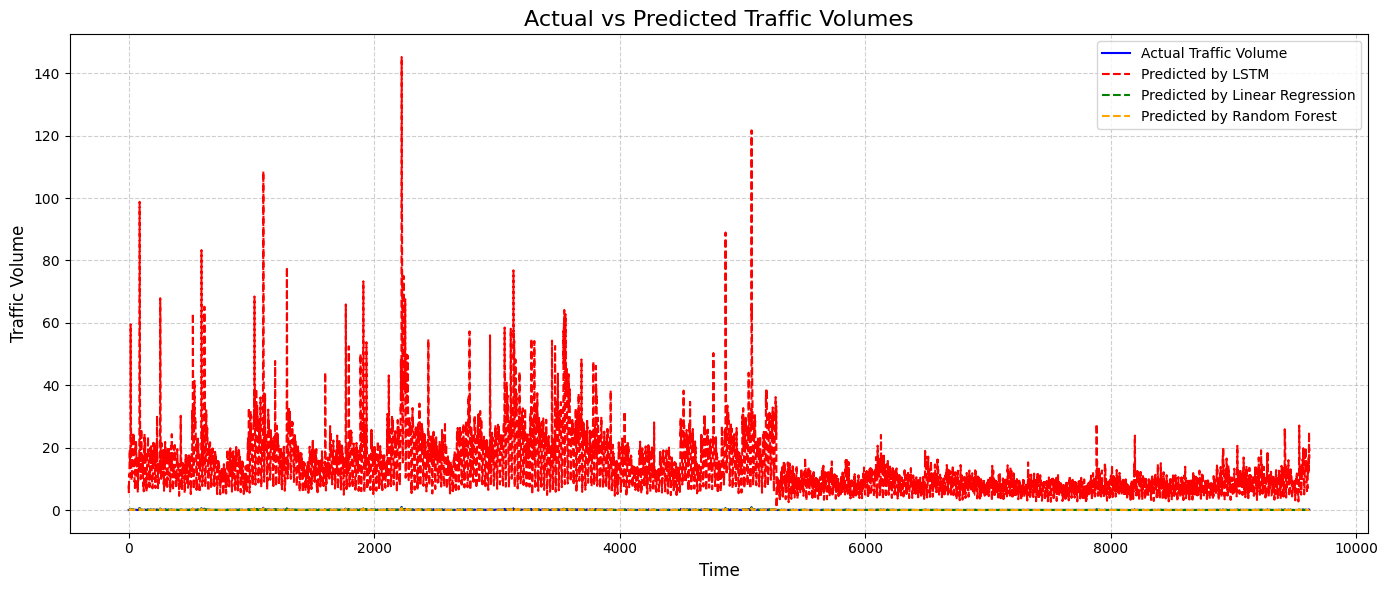

In [15]:
plt.figure(figsize=(14,6))
plt.plot(y_test, label='Actual Traffic Volume', color='blue')
plt.plot(y_pred_lstm, label='Predicted by LSTM', color='red', linestyle='--')
plt.plot(y_pred_lin, label='Predicted by Linear Regression', color='green', linestyle='--')
plt.plot(y_pred_rf, label='Predicted by Random Forest', color='orange', linestyle='--')
plt.title("Actual vs Predicted Traffic Volumes", fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Traffic Volume", fontsize=12)
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()